# **Imports**

In [ ]:
#uncomment this if you are running the notebook for the first time
#! pip install pretty_confusion_matrix
import torch
import torchvision
import torch.nn as nn  
import torch.optim as optim  
import torch.nn.functional as F  
from torch.utils.data import (
    DataLoader,
    Dataset,
) 
import torchvision.datasets as datasets
import torchvision.transforms as transforms 
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
from PIL import Image
from sklearn.metrics import roc_curve
import pandas as pd
from pretty_confusion_matrix import pp_matrix_from_data
from sklearn.metrics import roc_auc_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/dataset.zip" -d "/content/dataset"

# **Transformation & Visualization**

In [ ]:
data_transforms = transforms.Compose([
        transforms.Lambda(lambda x: x.to(torch.float32).repeat(3,1,1)),
        transforms.Resize((224,224)),
        ])


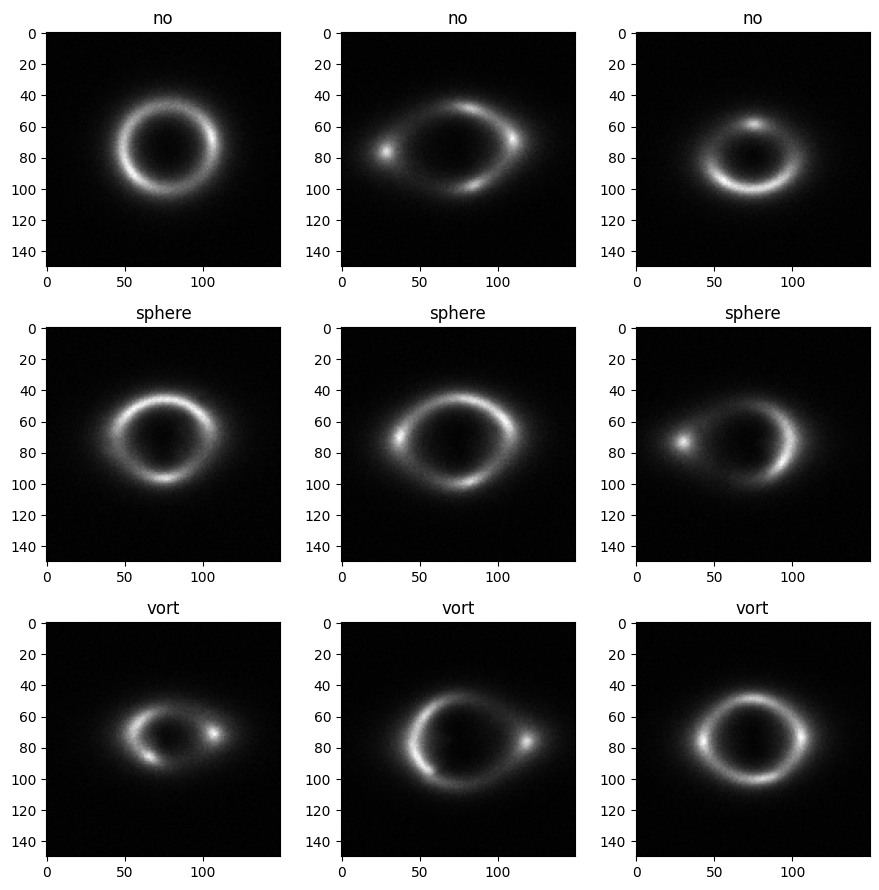

In [ ]:
subfolders = ["no", "sphere", "vort"]
n_images = 3
fig = plt.figure(figsize=(9,9))
for i, subfolder in enumerate(subfolders):

    image_files = os.listdir(os.path.join("/content/dataset/dataset/train", subfolder))

    for j, image_file in enumerate(image_files[:n_images]):

        img_array = np.load(os.path.join("/content/dataset/dataset/train", subfolder, image_file))
        img = Image.fromarray((img_array[0] * 255).astype(np.uint8))
        ax = fig.add_subplot(3, 3, i*3 + j + 1)
        ax.imshow(img, cmap='gray', vmin=0, vmax=255)
        ax.set_title(subfolder)


plt.tight_layout()
plt.show()

# **Data Augmentation**

In [ ]:
transform = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(100)], p=0.40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation([-90,90]),
    transforms.ToTensor()
])

In [ ]:
root_dir = "/content/dataset/dataset/train"
subfolders = ["no", "sphere", "vort"]
subdirs = os.listdir(root_dir)
for subdir in subfolders:
    subdir_path = os.path.join(root_dir, subdir)
    # Iterate over images
    images = os.listdir(subdir_path)
    for image in images:
        image_path = os.path.join(subdir_path, image)
        # Load image as numpy array
        image_array = np.load(image_path)
        # Convert array to float32 dtype
        image_array = np.float32(image_array)
        image_array = np.squeeze(image_array)
        # Convert array to PIL image
        pil_image = Image.fromarray(image_array)
        # Apply transform 2 times and save as new images
        for i in range(2):
            transformed_image = transform(pil_image)
            # Convert back to numpy array
            transformed_image = transformed_image.numpy()
            # Save as .npy file with a suffix
            new_image_path = image_path[:-4] + f"_{i}.npy"
            np.save(new_image_path, transformed_image)

In [ ]:
dir_list = os.listdir("/content/dataset/dataset/train/no")
dir_length = len(dir_list)
print(dir_length)

30000


# **Model Definition**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.mobilenet_v3_large(pretrained=True);
model.classifier = nn.Sequential(
    nn.Linear(960, 3)
)
model.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

# **Data Loader**

In [ ]:
def npy_loader(path):
  sample = torch.from_numpy(np.load(path))
  return sample



train_dataset = datasets.DatasetFolder(
  root='/content/dataset/dataset/train',
  loader=npy_loader,
  extensions=['.npy'],
  transform = data_transforms
)


train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

val_dataset = datasets.DatasetFolder(
  root='/content/dataset/dataset/val',
  loader=npy_loader,
  extensions=['.npy'],
  transform = data_transforms
)
val_dataloader = DataLoader(val_dataset, batch_size=50,shuffle=False)

# **Definitions and Helper Functions**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [ ]:
def evaluate(model, dataloader, criterion):
    losses = []
    all_targets = []
    all_scores = []
    probabilities = []
    model.eval()

    with torch.no_grad():
        for data, targets in dataloader:

            data = data.to(device=device)
            targets = targets.to(device=device)

            scores = model(data)
            prob = F.softmax(scores, dim=1)
            probabilities.extend(prob.tolist())

            loss = criterion(scores, targets)

            losses.append(loss.item())
            all_targets.extend(targets.cpu().numpy())
            all_scores.extend(scores.detach().cpu().numpy())

        avg_loss = sum(losses) / len(losses)


        labels = np.array(all_targets)
        probabilities = np.array(probabilities)
        avg_auc = roc_auc_score(labels, probabilities, multi_class='ovr')

        _, preds = torch.max(torch.tensor(all_scores), 1)
        correct = (preds == torch.tensor(all_targets)).float()
        accuracy = torch.sum(correct) / len(all_targets)
        
        y_pred = preds.numpy()
        y_true = np.array(all_targets)

         

    return avg_loss, avg_auc, accuracy, y_pred, y_true

# **Model Training**

In [16]:
AUC_list = []
best_auc_val_score = 0
for epoch in range(30):
    losses = []
    all_targets = []
    all_scores = []
    probabilities = []
    # set model to training mode
    model.train()

    for data, targets in tqdm(train_loader):
      
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        prob = F.softmax(scores, dim=1)
        probabilities.extend(prob.tolist())
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        all_targets.extend(targets.cpu().numpy())
        all_scores.extend(scores.detach().cpu().numpy())

    avg_loss_train = sum(losses) / len(losses)


    labels = np.array(all_targets)
    probabilities = np.array(probabilities)

    avg_auc = roc_auc_score(labels, probabilities, multi_class='ovr')
    AUC_list.append(avg_auc)

    _, preds = torch.max(torch.tensor(all_scores), 1)
    correct = (preds == torch.tensor(all_targets)).float()
    accuracy = torch.sum(correct) / len(all_targets)
    

    avg_loss_test, avg_auc_test, accuracy_test, _ ,_ = evaluate(model,val_dataloader,criterion)
    scheduler.step(avg_loss_test)
    if avg_auc_test > best_auc_val_score:
            # Update the best validation score
            best_auc_val_score = avg_auc_test
            
            # Save the model state dictionary and other information
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_score': avg_auc_test
            }, 'best_model.pth')

    print(f"\nEpoch No. {epoch}\n======\n")
    print(f"Training Loss is {avg_loss_train:.5f}, Validation Loss is {avg_loss_test:.5f}")
    print(f"Training AUC is {avg_auc:.5f}, Validation AUC is {avg_auc_test:.5f}")
    print(f"Training Accuracy is {accuracy:.5f}, Validation Accuracy is{accuracy_test:.5f}")
    print("===============\n")

100%|██████████| 1800/1800 [08:50<00:00,  3.39it/s]



Epoch No. 0

Training Loss is 0.25248, Validation Loss is 0.25960
Training AUC is 0.98001, Validation AUC is 0.98043
Training Accuracy is 0.90636, Validation Accuracy is0.90667



100%|██████████| 1800/1800 [08:46<00:00,  3.42it/s]



Epoch No. 1

Training Loss is 0.21982, Validation Loss is 0.31558
Training AUC is 0.98444, Validation AUC is 0.98276
Training Accuracy is 0.91903, Validation Accuracy is0.87613



100%|██████████| 1800/1800 [08:55<00:00,  3.36it/s]



Epoch No. 2

Training Loss is 0.19565, Validation Loss is 0.24998
Training AUC is 0.98736, Validation AUC is 0.98022
Training Accuracy is 0.92979, Validation Accuracy is0.91160



100%|██████████| 1800/1800 [08:49<00:00,  3.40it/s]



Epoch No. 3

Training Loss is 0.17385, Validation Loss is 0.27840
Training AUC is 0.98982, Validation AUC is 0.98095
Training Accuracy is 0.93796, Validation Accuracy is0.89253



100%|██████████| 1800/1800 [08:48<00:00,  3.41it/s]



Epoch No. 4

Training Loss is 0.15942, Validation Loss is 0.20618
Training AUC is 0.99134, Validation AUC is 0.98892
Training Accuracy is 0.94241, Validation Accuracy is0.93453



100%|██████████| 1800/1800 [08:55<00:00,  3.36it/s]



Epoch No. 5

Training Loss is 0.14784, Validation Loss is 0.16446
Training AUC is 0.99253, Validation AUC is 0.99111
Training Accuracy is 0.94668, Validation Accuracy is0.94747



100%|██████████| 1800/1800 [08:48<00:00,  3.40it/s]



Epoch No. 6

Training Loss is 0.13558, Validation Loss is 0.25640
Training AUC is 0.99365, Validation AUC is 0.98265
Training Accuracy is 0.95182, Validation Accuracy is0.91400



100%|██████████| 1800/1800 [08:44<00:00,  3.43it/s]



Epoch No. 7

Training Loss is 0.12723, Validation Loss is 0.22370
Training AUC is 0.99432, Validation AUC is 0.98849
Training Accuracy is 0.95426, Validation Accuracy is0.93200



100%|██████████| 1800/1800 [08:40<00:00,  3.46it/s]



Epoch No. 8

Training Loss is 0.11557, Validation Loss is 0.16902
Training AUC is 0.99523, Validation AUC is 0.99171
Training Accuracy is 0.95867, Validation Accuracy is0.94267



100%|██████████| 1800/1800 [08:48<00:00,  3.41it/s]



Epoch No. 9

Training Loss is 0.10926, Validation Loss is 0.20295
Training AUC is 0.99576, Validation AUC is 0.98754
Training Accuracy is 0.96027, Validation Accuracy is0.93240



100%|██████████| 1800/1800 [08:47<00:00,  3.41it/s]



Epoch No. 10

Training Loss is 0.06093, Validation Loss is 0.17211
Training AUC is 0.99848, Validation AUC is 0.99319
Training Accuracy is 0.97886, Validation Accuracy is0.95400



100%|██████████| 1800/1800 [08:55<00:00,  3.36it/s]



Epoch No. 11

Training Loss is 0.04760, Validation Loss is 0.16937
Training AUC is 0.99906, Validation AUC is 0.99205
Training Accuracy is 0.98313, Validation Accuracy is0.95253



100%|██████████| 1800/1800 [08:50<00:00,  3.39it/s]



Epoch No. 12

Training Loss is 0.04080, Validation Loss is 0.32601
Training AUC is 0.99936, Validation AUC is 0.98720
Training Accuracy is 0.98501, Validation Accuracy is0.93000



100%|██████████| 1800/1800 [08:47<00:00,  3.41it/s]



Epoch No. 13

Training Loss is 0.03600, Validation Loss is 0.26386
Training AUC is 0.99949, Validation AUC is 0.99089
Training Accuracy is 0.98749, Validation Accuracy is0.94773



100%|██████████| 1800/1800 [08:45<00:00,  3.42it/s]



Epoch No. 14

Training Loss is 0.01537, Validation Loss is 0.37053
Training AUC is 0.99990, Validation AUC is 0.98840
Training Accuracy is 0.99460, Validation Accuracy is0.89987



100%|██████████| 1800/1800 [08:50<00:00,  3.39it/s]



Epoch No. 15

Training Loss is 0.01119, Validation Loss is 0.26767
Training AUC is 0.99994, Validation AUC is 0.99302
Training Accuracy is 0.99630, Validation Accuracy is0.95520



100%|██████████| 1800/1800 [08:53<00:00,  3.38it/s]



Epoch No. 16

Training Loss is 0.01101, Validation Loss is 0.25472
Training AUC is 0.99995, Validation AUC is 0.99335
Training Accuracy is 0.99627, Validation Accuracy is0.95787



100%|██████████| 1800/1800 [08:47<00:00,  3.41it/s]



Epoch No. 17

Training Loss is 0.00975, Validation Loss is 0.31549
Training AUC is 0.99996, Validation AUC is 0.99249
Training Accuracy is 0.99664, Validation Accuracy is0.94933



100%|██████████| 1800/1800 [08:50<00:00,  3.40it/s]



Epoch No. 18

Training Loss is 0.00365, Validation Loss is 0.26905
Training AUC is 1.00000, Validation AUC is 0.99378
Training Accuracy is 0.99879, Validation Accuracy is0.95773



100%|██████████| 1800/1800 [08:44<00:00,  3.43it/s]



Epoch No. 19

Training Loss is 0.00280, Validation Loss is 0.27747
Training AUC is 1.00000, Validation AUC is 0.99376
Training Accuracy is 0.99911, Validation Accuracy is0.95293



100%|██████████| 1800/1800 [08:44<00:00,  3.43it/s]



Epoch No. 20

Training Loss is 0.00327, Validation Loss is 0.35951
Training AUC is 1.00000, Validation AUC is 0.99278
Training Accuracy is 0.99889, Validation Accuracy is0.95653



100%|██████████| 1800/1800 [08:44<00:00,  3.43it/s]



Epoch No. 21

Training Loss is 0.00242, Validation Loss is 0.35548
Training AUC is 1.00000, Validation AUC is 0.99317
Training Accuracy is 0.99921, Validation Accuracy is0.95653



100%|██████████| 1800/1800 [08:47<00:00,  3.41it/s]



Epoch No. 22

Training Loss is 0.00128, Validation Loss is 0.42203
Training AUC is 1.00000, Validation AUC is 0.99250
Training Accuracy is 0.99958, Validation Accuracy is0.95427



100%|██████████| 1800/1800 [08:58<00:00,  3.34it/s]



Epoch No. 23

Training Loss is 0.00086, Validation Loss is 0.32950
Training AUC is 1.00000, Validation AUC is 0.99343
Training Accuracy is 0.99969, Validation Accuracy is0.95840



100%|██████████| 1800/1800 [08:45<00:00,  3.43it/s]



Epoch No. 24

Training Loss is 0.00087, Validation Loss is 0.37036
Training AUC is 1.00000, Validation AUC is 0.99313
Training Accuracy is 0.99971, Validation Accuracy is0.95773



100%|██████████| 1800/1800 [08:47<00:00,  3.41it/s]



Epoch No. 25

Training Loss is 0.00089, Validation Loss is 0.34547
Training AUC is 1.00000, Validation AUC is 0.99335
Training Accuracy is 0.99970, Validation Accuracy is0.95720



100%|██████████| 1800/1800 [08:53<00:00,  3.37it/s]



Epoch No. 26

Training Loss is 0.00046, Validation Loss is 0.37574
Training AUC is 1.00000, Validation AUC is 0.99345
Training Accuracy is 0.99986, Validation Accuracy is0.95787



100%|██████████| 1800/1800 [08:41<00:00,  3.45it/s]



Epoch No. 27

Training Loss is 0.00024, Validation Loss is 0.35669
Training AUC is 1.00000, Validation AUC is 0.99349
Training Accuracy is 0.99996, Validation Accuracy is0.95813



100%|██████████| 1800/1800 [08:51<00:00,  3.38it/s]



Epoch No. 28

Training Loss is 0.00044, Validation Loss is 0.40091
Training AUC is 1.00000, Validation AUC is 0.99318
Training Accuracy is 0.99986, Validation Accuracy is0.95667



100%|██████████| 1800/1800 [08:53<00:00,  3.37it/s]



Epoch No. 29

Training Loss is 0.00033, Validation Loss is 0.38377
Training AUC is 1.00000, Validation AUC is 0.99338
Training Accuracy is 0.99992, Validation Accuracy is0.95933



# **Loading Best Model**

In [23]:
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# **Testing on Test Set**

In [24]:
avg_loss_test, avg_auc_test, accuracy_test,y_pred,y_true = evaluate(model,
                                                      val_dataloader,
                                                      criterion)

print(f"\nValidation AUC score is {avg_auc_test:.5f}")
    
print(f"Validation Accuracy is {accuracy_test:.5f}")

print(f"Validation Loss is {avg_loss_test:.5f}")


Validation AUC score is 0.99378
Validation Accuracy is 0.95773
Validation Loss is 0.26905


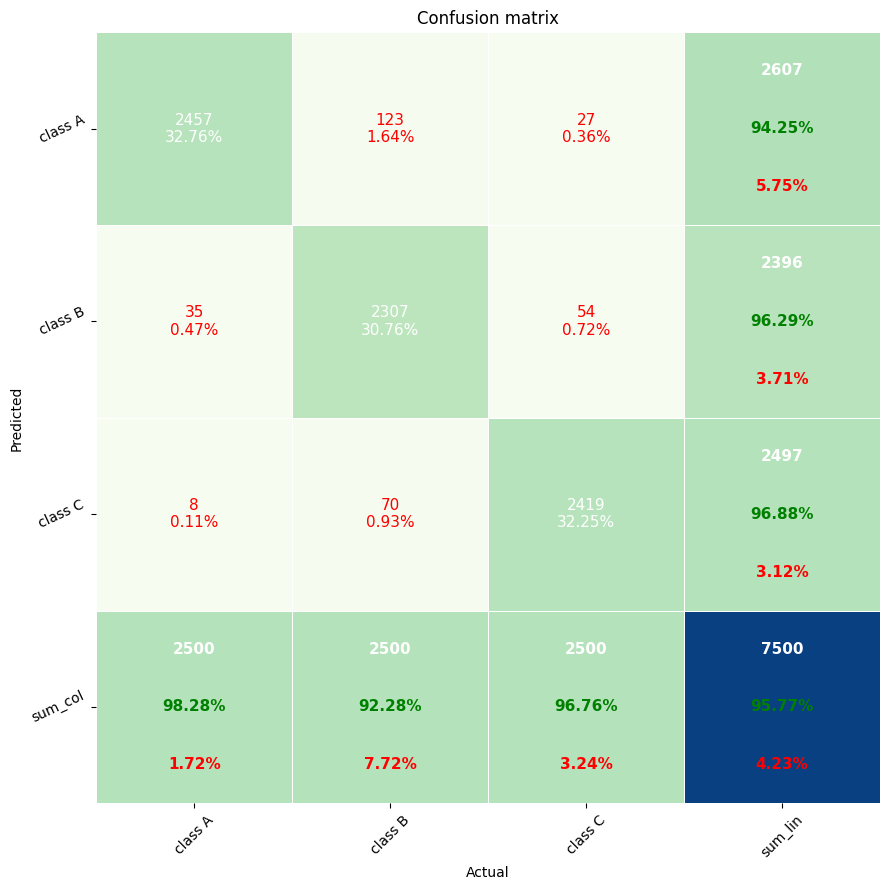

In [25]:
pp_matrix_from_data(y_true, y_pred,cmap = 'GnBu')

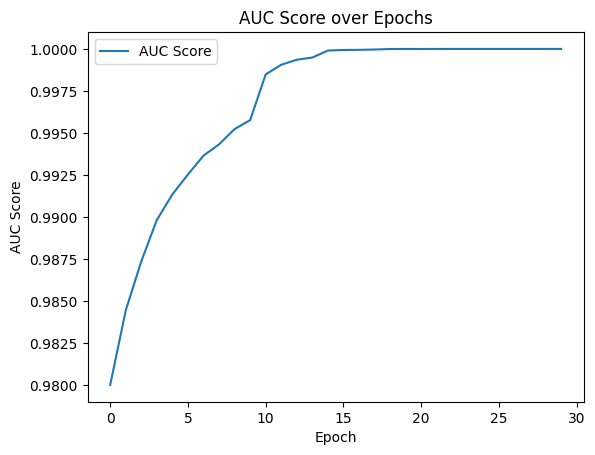

In [26]:
plt.plot(range(0, 30), AUC_list)
plt.xlabel("Epoch")
plt.ylabel("AUC Score")
plt.title("AUC Score over Epochs")
plt.legend(["AUC Score"])

plt.show() 

# **ROC Cruve**

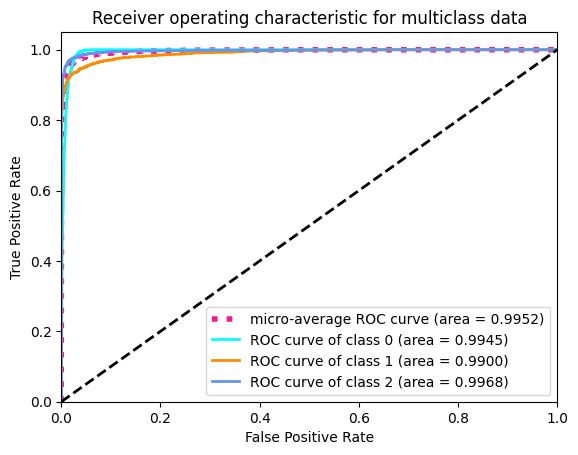

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

model.to(device)

y_score = []
y_true = []
with torch.no_grad():

    for X_batch, y_batch in val_dataloader: 
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        logits = model(X_batch)
        probs = F.softmax(logits, dim=1)
        y_score.append(probs)
        y_true.append(y_batch)

y_score = torch.cat(y_score).cpu().numpy() 
y_true = torch.cat(y_true).cpu().numpy()
y_test = label_binarize(y_true, classes=[0, 1, 2]) 
n_classes = y_test.shape[1]



fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multiclass data')
plt.legend(loc="lower right")
plt.show()

In [22]:
torch.save(model.state_dict(), '/content/classification_model.pth')